Goal: Build and train a neural network for classifying handwritten digits from the MNIST dataset

# Warm-up


Part 0: Warm-up - 2D Linear Logistic Regression

Data generated. x_linear shape: torch.Size([200, 2]) y_linear shape: torch.Size([200, 1])


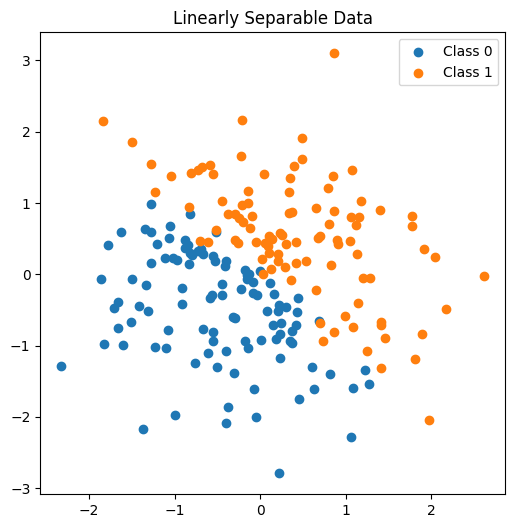

In [ ]:
# import libraries and generate linearly separable data
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

n_data_linear = 200
x_linear = torch.randn((n_data_linear, 2))
noise = torch.randn(n_data_linear) * 0.2
# the decision boundary is roughly x1 + x2 = 0
threshold = x_linear[:, 0] + x_linear[:, 1] + noise
y_linear = torch.zeros((n_data_linear, 1))
# assign class 1 if x1 + x2 > 0, otherwise class 0
y_linear[threshold > 0] = 1

print("Data generated. x_linear shape:", x_linear.shape, "y_linear shape:", y_linear.shape)
plt.figure(figsize=(6, 6))
plt.scatter(x_linear[y_linear.squeeze() == 0][:, 0], x_linear[y_linear.squeeze() == 0][:, 1], label='Class 0')
plt.scatter(x_linear[y_linear.squeeze() == 1][:, 0], x_linear[y_linear.squeeze() == 1][:, 1], label='Class 1')
plt.title("Linearly Separable Data")
plt.legend()
plt.show()

In [ ]:
# define the Linear Model
class LinearLogisticModel(nn.Module):
    def __init__(self):
        super().__init__()
        # The model aims to learn sigmoid(a*x1 + b*x2 + c)
        # Using nn.Linear(2, 1) is a much cleaner way to define a, b, c
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        # The output is a logit
        logits = self.layer(x)
        # Apply sigmoid function to get a probability
        return torch.sigmoid(logits)

In [ ]:
# initialize model, loss function, and optimizer
linear_model = LinearLogisticModel() #
# Binary Cross Entropy is the standard loss for binary classification
loss_fn_binary = nn.BCELoss()
optimizer_linear = optim.SGD(linear_model.parameters(), lr=0.1)

# test initial accuracy before training
with torch.no_grad():
    initial_probs = linear_model(x_linear)
    initial_preds = (initial_probs >= 0.5).float()
    initial_accuracy = (initial_preds == y_linear).float().mean()
    print(f"Initial accuracy: {initial_accuracy.item():.2%}")

Initial accuracy: 49.50%


Starting training...
Epoch 40, Loss: 0.4567
Epoch 80, Loss: 0.3590
Epoch 120, Loss: 0.3123
Epoch 160, Loss: 0.2836
Epoch 200, Loss: 0.2634

Final accuracy: 94.00%


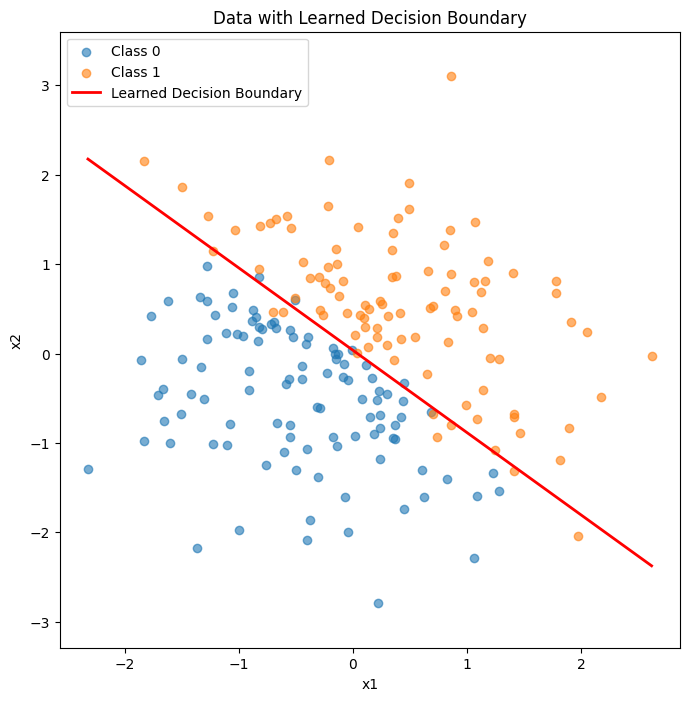

In [ ]:
# training & evaluate
epochs = 200
print("Starting training...")
for epoch in range(epochs):
    # forward pass
    y_pred_prob = linear_model(x_linear) #
    # calculate loss
    loss = loss_fn_binary(y_pred_prob, y_linear)

    # backward and optimize
    optimizer_linear.zero_grad()
    loss.backward() #
    optimizer_linear.step()

    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

with torch.no_grad():
    final_probs = linear_model(x_linear)
    final_preds = (final_probs >= 0.5).float()
    final_accuracy = (final_preds == y_linear).float().mean()
    print(f"\nFinal accuracy: {final_accuracy.item():.2%}")

# get the learned weights and bias from the trained model
W = linear_model.layer.weight.data
b = linear_model.layer.bias.data
w1, w2 = W[0, 0], W[0, 1]
bias = b[0]

# to plot the line w1*x1 + w2*x2 + b = 0, we can express x2 in terms of x1:
# x2 = (-w1*x1 - b) / w2
x_boundary = torch.linspace(x_linear[:, 0].min(), x_linear[:, 0].max(), 100)
y_boundary = (-w1 * x_boundary - bias) / w2

# plot the original data points
plt.figure(figsize=(8, 8))
plt.scatter(x_linear[y_linear.squeeze() == 0][:, 0], x_linear[y_linear.squeeze() == 0][:, 1], label='Class 0', alpha=0.6)
plt.scatter(x_linear[y_linear.squeeze() == 1][:, 0], x_linear[y_linear.squeeze() == 1][:, 1], label='Class 1', alpha=0.6)

# plot the learned decision boundary
plt.plot(x_boundary, y_boundary, color='r', linewidth=2, label='Learned Decision Boundary')
plt.title("Data with Learned Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.ylim(x_linear[:, 1].min()-0.5, x_linear[:, 1].max()+0.5) # Adjust plot limits
plt.show()

# Logistic Regression of MINIST using PyTorch

We start with the approach that we used last week (starting everything from scratch).

Then we gradually replace our naive implementation with standard PyTorch components, which enables more advanced techniques.

Part 1: Setup and Data Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print(f"Training set shape: {trainset.data.shape}")
print(f"Testing set shape: {testset.data.shape}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.59MB/s]

Training set shape: torch.Size([60000, 28, 28])
Testing set shape: torch.Size([10000, 28, 28])


You see, the shape is [data_size, pixel_dim, pixel_dim]. The data point is a 2D array.

But we are going to train a logistic regressor $y=W \cdot X+b$, which requires a 1D array of $X$.

Here we use a naive way to **flatten** the 2D array: `reshape()` method.

PyTorch also has a `view()` method which is very similar. The main difference is:

  * **`view()`**: Requires the tensor to be **contiguous** in memory. A tensor is contiguous if its elements are stored sequentially in memory without gaps. If the tensor is not contiguous (e.g., after a transpose operation), you must call `.contiguous()` first. A key feature of `view()` is that the new tensor is not a copy. It's a "view" into the same memory block as the original tensor. This makes it very efficient because no data is duplicated. However, it also means that if you change an element in the new tensor, the change will be reflected in the original tensor, and vice versa.
  * **`reshape()`**: Is more flexible. If the tensor is contiguous, `reshape()` will behave like `view()` (returning a view). If it's not contiguous, `reshape()` will create a copy of the data with the new shape.

In modern PyTorch, it's often recommended to use `reshape()` because it's more robust and will do the right thing (either create a view or a copy) automatically. However, understanding `view()` is important for grasping how PyTorch handles tensor memory.

Training data shape: torch.Size([60000, 784])
Testing data shape: torch.Size([10000, 784])


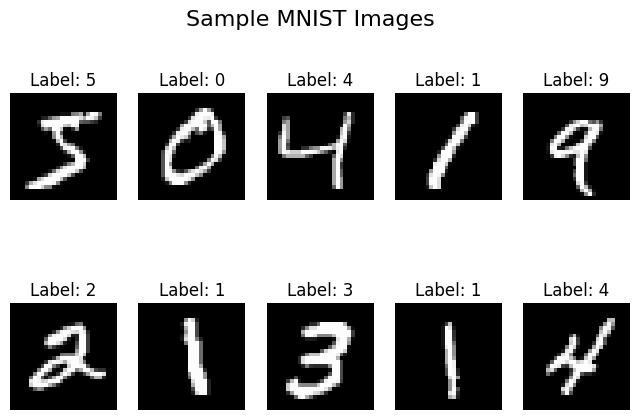

In [ ]:
# Preprocess and flatten the data
def preprocess_data(dataset):
    # normalize pixel values and flatten images
    data = (dataset.data / 255.0) - 0.5
    flattened_data = data.view(data.shape[0], -1) # flatten from [N, 28, 28] to [N, 784]
    targets = dataset.targets
    return flattened_data, targets

x_train, y_train = preprocess_data(trainset)
x_test, y_test = preprocess_data(testset)

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

plt.figure(figsize=(8, 5))
for i in range(10): # display the first 10 images
    plt.subplot(2, 5, i + 1)
    # the training data is flattened, so we reshape it back to 28x28 for display
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i].item()}")
    plt.axis('off')
plt.suptitle('Sample MNIST Images', fontsize=16)
plt.show()

Part 2: The First Model - A Fully Manual Approach

In [ ]:
# define parameters manually
A = torch.nn.Parameter(torch.randn(784, 10), requires_grad=True) # Input: 784, Output: 10
b = torch.nn.Parameter(torch.randn(10), requires_grad=True)

# define the model as a function
def f(x, weights, bias):
    """
    x: input data, shape: [batch_size, 784]
    weights: learned weights, shape: [784, 10]
    bias: learned bias, shape: [10]
    """
    logits = x @ weights + bias # linear transformation, output shape: (batch_size, 10)
    return torch.nn.functional.softmax(logits, dim=1) # softmax activation, output shape: (batch_size, 10)

# manual training loop
learning_rate = 0.5
for epoch in range(10): # train for fewer epochs for demonstration
    # forward pass
    probabilities = f(x_train, A, b)

    # manual loss calculation (Cross-Entropy)
    # It uses advanced indexing to select only the probabilities that the model assigned to the correct classes.
    loss = -torch.log(probabilities[range(y_train.shape[0]), y_train]).mean()

    # backward pass
    loss.backward()

    # manual gradient descent update
    with torch.no_grad():
        A -= learning_rate * A.grad
        b -= learning_rate * b.grad

        # zero the gradients
        A.grad.zero_()
        b.grad.zero_()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 15.5232
Epoch 2, Loss: 12.2255
Epoch 3, Loss: 10.2904
Epoch 4, Loss: 8.9743
Epoch 5, Loss: 8.2665
Epoch 6, Loss: 7.7369
Epoch 7, Loss: 7.2791
Epoch 8, Loss: 6.8564
Epoch 9, Loss: 6.4801
Epoch 10, Loss: 6.1335


Loss function calculation:

```
loss = -torch.log(probabilities[range(y_train.shape[0]), y_train]).mean()
```

🧠 What it does: For each image (each row), it plucks out the probability value from the column corresponding to the correct answer.

For example, if the first image's correct label is class 5 (`y_train[0] == 5`), this code selects `probabilities[0, 5]`. If the second image's correct label is 0, it selects `probabilities[1, 0]`.

Part 3: The Second Model - Using nn.Module and an Optimizer

In [ ]:
# 1. Define model as a class
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # use nn.Linear is better, but we show manual definition here for progression
        self.A = nn.Parameter(torch.randn(input_size, output_size))
        self.b = nn.Parameter(torch.randn(output_size))

    # 2. Define forward pass
    def forward(self, x):
        logits = x @ self.A + self.b
        return logits # Return logits, as CrossEntropyLoss prefers it

# Initialize model, loss function, and optimizer
model = SimpleModel(784, 10)
loss_function = nn.CrossEntropyLoss() # PyTorch's built-in loss function
optimizer = optim.SGD(model.parameters(), lr=0.5) # 3. Use an optimizer

# 4. Cleaner training loop
for epoch in range(10):
    # forward pass
    logits = model(x_train)

    # calculate loss
    loss = loss_function(logits, y_train)

    # standard PyTorch training steps
    optimizer.zero_grad() # clear previous gradients
    loss.backward() # compute new gradients
    optimizer.step() # update model parameters


    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 18.4786
Epoch 2, Loss: 14.1963
Epoch 3, Loss: 11.4783
Epoch 4, Loss: 9.7095
Epoch 5, Loss: 8.5861
Epoch 6, Loss: 7.9503
Epoch 7, Loss: 7.4685
Epoch 8, Loss: 7.0594
Epoch 9, Loss: 6.7274
Epoch 10, Loss: 6.3810


Part 4: The Third Model - Use `nn.Linear()` component

Epoch 1, Loss: 2.3165
Epoch 2, Loss: 2.1413
Epoch 3, Loss: 2.0003
Epoch 4, Loss: 1.9322
Epoch 5, Loss: 1.8265
Epoch 6, Loss: 1.8249
Epoch 7, Loss: 1.7006
Epoch 8, Loss: 1.6260
Epoch 9, Loss: 1.5717
Epoch 10, Loss: 1.5456
Visualizing the weights learned by the StandardModel...


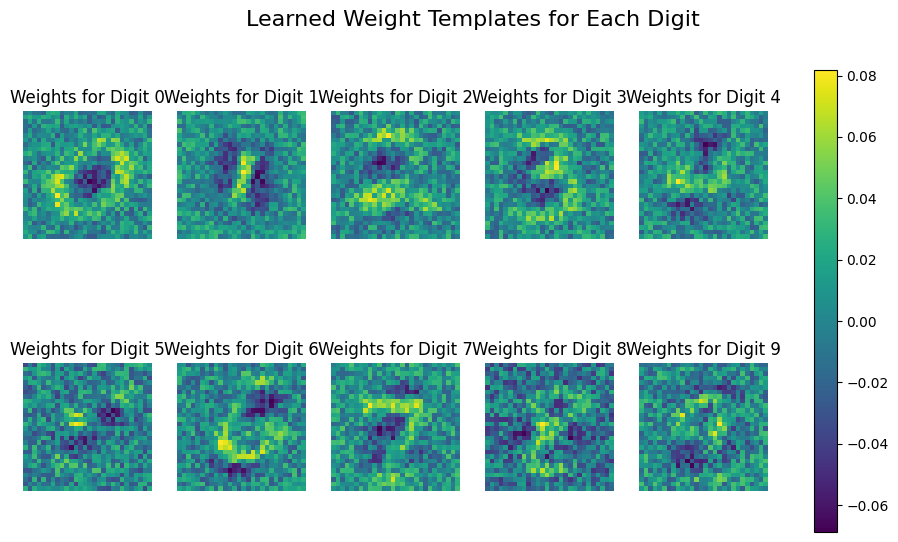

In [ ]:
# Define model using built-in layers
class StandardModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        logits = self.linear_layer(x)
        return logits

# Initialize the standard model
model = StandardModel(784, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2) # adjusted learning rate

# Training loop is identical
for epoch in range(10):
    logits = model(x_train)
    loss = loss_function(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("Visualizing the weights learned by the StandardModel...")

# access the weights from the trained model's linear layer
trained_weights = model.linear_layer.weight.data

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Learned Weight Templates for Each Digit', fontsize=16)

for i, ax in enumerate(axes.flat):
    # reshape the 784-element weight vector for digit 'i' into a 28x28 image
    weight_image = trained_weights[i].reshape(28, 28)
    im = ax.imshow(weight_image, cmap='viridis') # 'viridis' colormap shows positive/negative weights clearly
    ax.set_title(f"Weights for Digit {i}")
    ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Part 5: The Fourth Model - A Deeper Network

In [ ]:
class DeeperModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # 1. Define layers
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh() # Activation function

    def forward(self, x):
        # 2. Define the computation flow
        hidden_output = self.layer_1(x)
        activated_output = self.tanh(hidden_output)
        logits = self.layer_2(activated_output)
        return logits

Part 6: Training with Stochastic Gradient Descent (SGD)

In [ ]:
# 1. Helper function for batching
def get_batch(x, y, batch_size):
    n = x.shape[0]
    indices = random.sample(range(n), k=batch_size)
    x_batch = x[indices]
    y_batch = y[indices]
    return x_batch, y_batch

# initialize the deeper model
model = DeeperModel(784, 1000, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

# training parameters
epochs = 10
batch_size = 1024
batch_count = 60000 // batch_size

loss_history = []

# 2. Nested training loop
for epoch in range(epochs):
    total_loss = 0
    for _ in range(batch_count):
        x_batch, y_batch = get_batch(x_train, y_train, batch_size)

        logits = model(x_batch)
        loss = loss_function(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / batch_count
    loss_history.append(avg_loss)

    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")



Epoch 1, Average Loss: 0.8798
Epoch 2, Average Loss: 0.4330
Epoch 3, Average Loss: 0.3765
Epoch 4, Average Loss: 0.3475
Epoch 5, Average Loss: 0.3349
Epoch 6, Average Loss: 0.3242
Epoch 7, Average Loss: 0.3149
Epoch 8, Average Loss: 0.2985
Epoch 9, Average Loss: 0.2958
Epoch 10, Average Loss: 0.3040


Notice on `get_batch()`: Within a single epoch, you call get_batch() multiple times. Because a new random sample is drawn each time from the entire dataset, it is possible for a data point to be selected in one batch and then selected again in a different batch within the same epoch.

This is **different** from the standard training procedure where the **dataset is shuffled once**, and then the model iterates through every sample exactly one time per epoch.



Epoch 1, Average Loss: 0.8831
Epoch 2, Average Loss: 0.4320
Epoch 3, Average Loss: 0.3762
Epoch 4, Average Loss: 0.3469
Epoch 5, Average Loss: 0.3327
Epoch 6, Average Loss: 0.3202
Epoch 7, Average Loss: 0.3097
Epoch 8, Average Loss: 0.3067
Epoch 9, Average Loss: 0.3024
Epoch 10, Average Loss: 0.2995


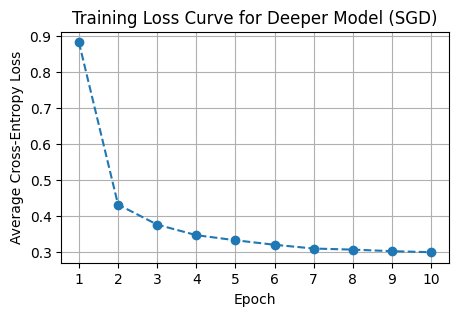

In [ ]:
import torch.utils.data as data

# initialize the deeper model
model = DeeperModel(784, 1000, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

# 1. Create a Dataset (TensorDataset is perfect for tensors you already have)
train_dataset = data.TensorDataset(x_train, y_train)

# 2. Create a DataLoader
batch_size = 1024
epochs = 10
# The DataLoader will handle shuffling and batching for you
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 3. Adapt the training loop to iterate directly over the loader
loss_history = []
for epoch in range(epochs):
    total_loss = 0
    # The loader provides the batches automatically
    for x_batch, y_batch in train_loader:
        logits = model(x_batch)
        loss = loss_function(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # The number of batches is len(train_loader)
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

plt.figure(figsize=(5, 3))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='--')
plt.title('Training Loss Curve for Deeper Model (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Average Cross-Entropy Loss')
plt.grid(True)
plt.xticks(range(1, epochs + 1))
plt.show()

Part 7: Evaluation

Forward pass on test data complete.
Overall Accuracy: 91.75%
Confusion Matrix (Text)
[[ 960    0    2    1    0    6    8    2    1    0]
 [   0 1107    2    2    0    4    4    2   14    0]
 [   8    8  917   13   16    6   12   15   33    4]
 [   3    1   22  901    0   43    2   18   14    6]
 [   1    2    3    2  936    1   12    2    6   17]
 [  10    3    2   25    8  793   14    8   21    8]
 [  14    3    4    1   14   14  904    3    1    0]
 [   3    8   21    7   10    1    0  959    2   17]
 [  10   12    8   27   10   47   12   13  830    5]
 [  11    8    2   10   57    6    0   40    7  868]]

Confusion Matrix (Heatmap)


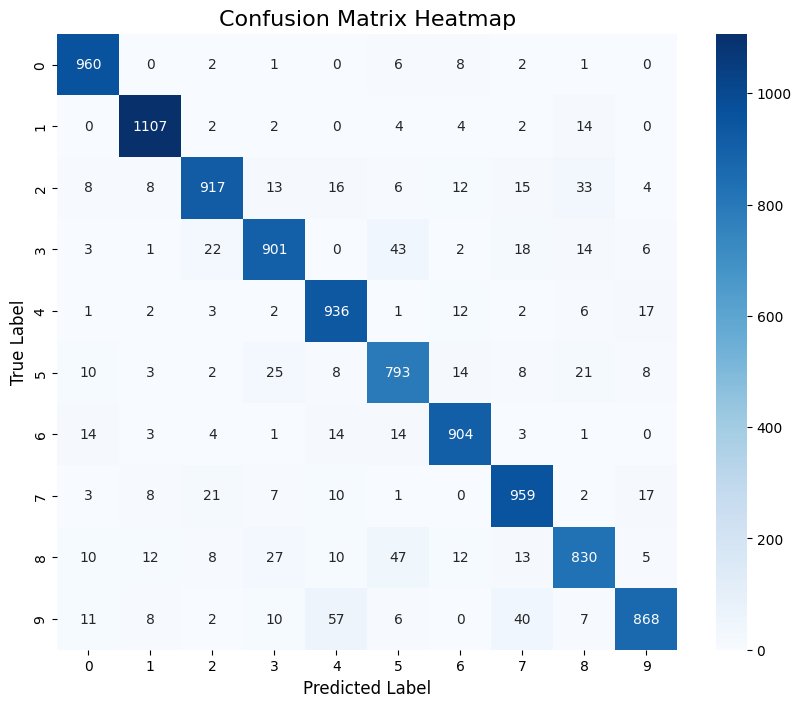

In [ ]:
model.eval() # set the model to evaluation mode (disables dropout, etc.)

# we don't need to calculate gradients for evaluation, so we use torch.no_grad() to save memory and computation
with torch.no_grad():
    logits = model(x_test)
    probabilities = torch.nn.functional.softmax(logits, dim=1)

print("Forward pass on test data complete.")

# get the predicted class for each image by finding the index with the highest probability
predicted_classes = torch.argmax(probabilities, dim=1)

# compare the predicted classes to the true labels to calculate accuracy
accuracy = (predicted_classes == y_test).float().mean()

print(f"Overall Accuracy: {accuracy.item() * 100:.2f}%")

# initialize a 10x10 matrix of zeros to store the counts
confusion_matrix = np.zeros((10, 10), dtype=np.int32)

# loop through all the test samples
for i in range(len(x_test)):
    actual_class = y_test[i].item()
    predicted_class = predicted_classes[i].item()

    # increment the count for the corresponding (actual, predicted) pair
    confusion_matrix[actual_class, predicted_class] += 1

print("Confusion Matrix (Text)")
print(confusion_matrix)

print("\nConfusion Matrix (Heatmap)")
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.title('Confusion Matrix Heatmap', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()